## Basic LDA example - An analysis of ~200 scientific articles
A visual explanation of topic modelling --> https://en.wikipedia.org/wiki/Topic_model

### Libraries
**Os** is for operating system routines.  
**Pdfminer** is needed for stripping the text from pdf documents.  
**Gensim** includes the LDA functions. State-of-the-art NLP library.  
**Nltk** is needed for stopwords. Basic text manipulation functions.  
**Spacy** is needed for lemmatization. Uses GloVe word embeddings. --> https://nlp.stanford.edu/projects/glove/  
**Pickle** is for saving intermediate steps to the disk.  
**pyLDAvis** is for visualising LDA results.  
**Matplotlib** plotting library  
**Pygam** is for generalized additive models (which are a generalisation of linear regression)  
**Numpy** data manipulation  
**Pandas** data manipulation. The most important Python library if you want to be a data scientist  
**Re** Regular expressions --> https://en.wikipedia.org/wiki/Regular_expression  

In [1]:
import os

from pdfminer.pdfparser import PDFParser
from pdfminer.pdfdocument import PDFDocument
from pdfminer.pdfpage import PDFPage
# From PDFInterpreter import both PDFResourceManager and PDFPageInterpreter
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.pdfdevice import PDFDevice
# Import this to raise exception whenever text extraction from PDF is not allowed
from pdfminer.pdfpage import PDFTextExtractionNotAllowed
from pdfminer.layout import LAParams, LTTextBox, LTTextLine
from pdfminer.converter import PDFPageAggregator

import gensim
from nltk.corpus import stopwords
import spacy 
import gensim.corpora as corpora
import pyLDAvis.gensim
import pickle
from pygam import LinearGAM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
from gensim.models import CoherenceModel

### Stripping text from pdf files
The function below is used for stripping the text from the pdf files. Below is an example of pdf file and the raw text stripped from it.
Pdfminer is not the most easiest pdf-stripper! There are easier options online. Also tools that can be used with a browser.

In [2]:
def convert_pdfminer(fname):
        fp = open(fname, 'rb')
        parser = PDFParser(fp)
        doc = PDFDocument(parser)
        rsrcmgr = PDFResourceManager()
        laparams = LAParams()
        device = PDFPageAggregator(rsrcmgr, laparams=laparams)
        interpreter = PDFPageInterpreter(rsrcmgr, device)
        text = ''
        for page in PDFPage.create_pages(doc):
            interpreter.process_page(page)
            layout = device.get_result()
            for lt_obj in layout:
                if isinstance(lt_obj, LTTextBox) or isinstance(lt_obj, LTTextLine):
                    text += lt_obj.get_text()
        return text

---
Define the data path.

In [3]:
# Different path, different computer
#data_path = 'E:/Onedrive_uwasa/OneDrive - University of Vaasa/Data/Yassin_BD_strategy/articles/'
data_path = 'C:/Users/mran/OneDrive - University of Vaasa/Data/Yassin_BD_strategy/articles/'

---
List pdf files in the destination directory **data_path**

In [4]:
files = os.listdir(data_path)
" | ".join(files[0:10])

'Abu-Rahma & Jaleel 2019.pdf | Adidam et al., 2012.pdf | Adkins et al. 2003.pdf | Aguirre et al. 2016.pdf | Ahituv et al., 1998.pdf | Akter et al., 2016.pdf | Aldea_et_al-2018.pdf | Analoui & Karami, 2002.pdf | Ardolino et al 2018.pdf | Arefin et al., 2015.pdf'

---
Load the stopwords from the NLTK library. Stopwords are useless words in the text that does not contain any information. At least information that is important in topic modeling. Very often you need to additional words to the stopwords. These are found by experimenting with the finished LDA model and identifying useless words from the topics. Below are listed the stopwords included in NLTK. More accounting/finance oriented stopword lists can be found from https://sraf.nd.edu/textual-analysis/resources/#StopWords

In [5]:
stop_words = stopwords.words("english")
stop_words.extend(['ieee','cid','et','al','pp','vol','fig','reproduction','prohibited','reproduced','permission'])
" | ".join(stop_words)

"i | me | my | myself | we | our | ours | ourselves | you | you're | you've | you'll | you'd | your | yours | yourself | yourselves | he | him | his | himself | she | she's | her | hers | herself | it | it's | its | itself | they | them | their | theirs | themselves | what | which | who | whom | this | that | that'll | these | those | am | is | are | was | were | be | been | being | have | has | had | having | do | does | did | doing | a | an | the | and | but | if | or | because | as | until | while | of | at | by | for | with | about | against | between | into | through | during | before | after | above | below | to | from | up | down | in | out | on | off | over | under | again | further | then | once | here | there | when | where | why | how | all | any | both | each | few | more | most | other | some | such | no | nor | not | only | own | same | so | than | too | very | s | t | can | will | just | don | don't | should | should've | now | d | ll | m | o | re | ve | y | ain | aren |

---
Collect the publicatin years from the file names using regular expressions. https://www.rexegg.com/regex-quickstart.html

In [6]:
file_years = [re.findall(r'\d+',name)[0] for name in files]
" | ".join(file_years)

'2019 | 2012 | 2003 | 2016 | 1998 | 2016 | 2018 | 2002 | 2018 | 2015 | 2017 | 2010 | 2016 | 2018 | 2012 | 2000 | 2013 | 2015 | 2008 | 2019 | 1996 | 2015 | 1997 | 2017 | 2017 | 2019 | 2018 | 2015 | 1999 | 2015 | 2019 | 2000 | 1997 | 2000 | 2017 | 2019 | 2014 | 2001 | 2008 | 2003 | 2010 | 2015 | 2009 | 2016 | 2003 | 2008 | 2007 | 2011 | 2000 | 2000 | 1995 | 2008 | 2011 | 2013 | 1997 | 2019 | 1997 | 2007 | 2016 | 2017 | 1995 | 1997 | 2016 | 2019 | 2000 | 1997 | 1996 | 2014 | 2018 | 2017 | 2016 | 2017 | 2001 | 1997 | 2003 | 2008 | 2004 | 2007 | 2009 | 2004 | 2006 | 2013 | 2013 | 2009 | 2004 | 2003 | 2011 | 1999 | 2017 | 2005 | 2018 | 2012 | 2011 | 2012 | 2009 | 2009 | 2013 | 2019 | 2019 | 2018 | 1998 | 1998 | 1998 | 2018 | 2007 | 2007 | 2000 | 2017 | 2012 | 1995 | 2018 | 1995 | 2019 | 1998 | 1999 | 1995 | 2006 | 2000 | 2012 | 2015 | 2011 | 2015 | 2007 | 1996 | 2010 | 2011 | 2018 | 1997 | 2017 | 2018 | 2012 | 2014 | 1998 | 2005 | 2019 | 2014 | 2007 | 2001 | 2017 | 2011 | 2019 | 2002 | 2009 

---
Go through files and strip text from the pdfs. Takes a lot of time!

In [ ]:
raw_text = []
for file in files:
    temp1 = convert_pdfminer(data_path+file)
    raw_text.append(temp1)

In [14]:
raw_text[0][0:1000]

'The current issue and full text archive of this journal is available on Emerald Insight at:\nwww.emeraldinsight.com/1934-8835.htm\nIJOA\n27,3\n690\nReceived 30 July 2017\nRevised 21 November 2017\n2 April 2018\n8 July 2018\nAccepted 3 August 2018\nPerceived uncertainty and use\nof environmental information\nin decision making\nThe case of the United Arab Emirates\nAbu Dhabi University, Al Ain, United Arab Emirates, and\nAli Abu-Rahma\nCollege of Business, Abu Dhabi University, Al Ain, United Arab Emirates\nBushra Jaleel\nAbstract\nPurpose – This paper aims to investigate the nature and prevalence of environmental scanning as practiced by\norganizations in the United Arab Emirates (UAE) and explore the impact of perceived uncertainty on the way\nvarious information sources are used in managerial decision-making. Speciﬁcally, by targeting ﬁrms in the\nregion, the paper examines whether the degree and frequency of scanning activities inﬂuence the relationship\nbetween perceived uncertain

---
Some of the pdf files were scanned documents. Pdfminer cannot strip text from these documents. You need to use a software capable of *optical character recoqnition*. These problematic pdfs were analysed elsewhere and the txt-file were added manually.

In [15]:
# ADD PROBLEMATIC DOCUMENTS
problem_path = 'C:/Users/mran/OneDrive - University of Vaasa/Data/Yassin_BD_strategy/problem_docs/'
problem_files = ['Cook et al 1998.txt',
 'Davenport et al., 2012.txt',
 'Dennis et al., 1997.txt',
 'Kiron et al., 2012.txt',
 'Lin & Hsu, 2007.txt',
 'Sawyerr et al 2003.txt',
 'Yasai-Ardekani & Nystrom, 1996 .txt']
for file in problem_files:
    file1 = open(problem_path + file,'r', encoding='ansi')
    raw_text.append(file1.read())

---
Add the years of the problematic documents to the *file_years* list.

In [16]:
# Years of problem documents
file_years.append('1998')
file_years.append('2012')
file_years.append('1997')
file_years.append('2012')
file_years.append('2007')
file_years.append('2003')
file_years.append('1996')

---
Below I tried to collect the publications dates of the documents from the metadata (file creation date). But this did not work, because the file creation date did not coincide with the original publication date.

In [ ]:
"""
import re
filedates = []
missing = []
for item in meta:
    try:
        temp = item[0]['CreationDate']
        temp2 = re.findall(r'\d+',str(temp))
        filedates.append(temp2[0])
    except:
        missing.append"""

---
Save the stripped raw text to the disk.

In [18]:
# Dump list of raw text documents to a file
fp = open('raw_text_list','wb')
pickle.dump(raw_text,fp)
fp.close()

---
Load the raw text from the disk.

In [7]:
# Load dump file
fp = open('raw_text_list','rb')
raw_text = pickle.load(fp)
fp.close()

---
Simple preprocessing using a Gensim function. Below is the function description: 

Convert a document into a list of lowercase tokens, ignoring tokens that are too short or too long.  
Parameters  
*doc (str)* – Input document.  
*deacc (bool, optional)* – Remove accent marks from tokens  
*min_len (int, optional)* – Minimum length of token (inclusive). Shorter tokens are discarded.  
*max_len (int, optional)*– Maximum length of token in result (inclusive). Longer tokens are discarded.  

In [8]:
docs_cleaned = []
for item in raw_text:
    tokens = gensim.utils.simple_preprocess(item)
    docs_cleaned.append(tokens)

In [9]:
" | ".join(docs_cleaned[0][0:200])

'the | current | issue | and | full | text | archive | of | this | journal | is | available | on | emerald | insight | at | www | emeraldinsight | com | htm | ijoa | received | july | revised | november | april | july | accepted | august | perceived | uncertainty | and | use | of | environmental | information | in | decision | making | the | case | of | the | united | arab | emirates | abu | dhabi | university | al | ain | united | arab | emirates | and | ali | abu | rahma | college | of | business | abu | dhabi | university | al | ain | united | arab | emirates | bushra | jaleel | abstract | purpose | this | paper | aims | to | investigate | the | nature | and | prevalence | of | environmental | scanning | as | practiced | by | organizations | in | the | united | arab | emirates | uae | and | explore | the | impact | of | perceived | uncertainty | on | the | way | various | information | sources | are | used | in | managerial | decision | making | speciﬁcally | by | targeting | ﬁrms |

---
Remove stopwords from the texts

In [10]:
docs_nostops = []
for item in docs_cleaned:
    red_tokens = [word for word in item if word not in stop_words]
    docs_nostops.append(red_tokens)

In [11]:
" | ".join(docs_nostops[0][0:200])

'current | issue | full | text | archive | journal | available | emerald | insight | www | emeraldinsight | com | htm | ijoa | received | july | revised | november | april | july | accepted | august | perceived | uncertainty | use | environmental | information | decision | making | case | united | arab | emirates | abu | dhabi | university | united | arab | emirates | ali | abu | rahma | college | business | abu | dhabi | university | united | arab | emirates | bushra | jaleel | abstract | purpose | paper | aims | investigate | nature | prevalence | environmental | scanning | practiced | organizations | united | arab | emirates | uae | explore | impact | perceived | uncertainty | way | various | information | sources | used | managerial | decision | making | speciﬁcally | targeting | ﬁrms | region | paper | examines | whether | degree | frequency | scanning | activities | inﬂuence | relationship | perceived | uncertainty | use | environmental | information | making | strategic | decisi

---
Spacy is a multi-purpose NLP tool that can be used, for example, to named-entity-recognition, parts-of-speech tagging, lemmatisation etc. Examples of these methods --> https://stanfordnlp.github.io/CoreNLP/  
We need here only the lemmatisation capabilties. Also we define that only nouns,adjectives,verbs and adverbs are saved. All other words are discarded. For these operations we use the medium size pretrained model.
Lemmatisation explanation from Wikipedia:  
* Lemmatisation (or lemmatization) in linguistics is the process of grouping together the inflected forms of a word so they can be analysed as a single item, identified by the word's lemma, or dictionary form. In computational linguistics, lemmatisation is the algorithmic process of determining the lemma of a word based on its intended meaning. Unlike **stemming**, lemmatisation depends on correctly identifying the intended part of speech and meaning of a word in a sentence, as well as within the larger context surrounding that sentence, such as neighboring sentences or even an entire document.  
The word "better" has "good" as its lemma. This link is missed by stemming, as it requires a dictionary look-up.  
The word "walk" is the base form for word "walking", and hence this is matched in both stemming and lemmatisation.

In [12]:
allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']

In [13]:
nlp = spacy.load('en_core_web_md', disable=['parser', 'ner'])

In [14]:
docs_lemmas = []
for red_tokens in docs_nostops:
    doc = nlp(" ".join(red_tokens))
    docs_lemmas.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])

In [15]:
" | ".join(docs_lemmas[0][0:200])

'current | issue | full | text | archive | journal | available | www | com | receive | revise | accept | perceive | uncertainty | use | environmental | information | decision | make | paper | aim | investigate | nature | prevalence | environmental | scanning | practice | organization | unite | explore | impact | perceive | uncertainty | way | various | information | source | use | managerial | decision | make | speciﬁcally | target | examine | degree | frequency | scanning | activity | inﬂuence | relationship | perceive | uncertainty | use | environmental | information | make | strategic | decision | design | methodology | approach | use | research | design | self | questionnaire | main | mode | data | collection | use | quantitative | data | analysis | tool | answer | research | question | finding | study | ﬁnd | perceive | environmental | uncertainty | signiﬁcantly | inﬂuence | effort | organization | turn | use | environmental | information | decision | make | additionally | ﬁnding 

---
Bigrams and trigrams are two- and three-word (token) strings that "belong together". Like "big_data" and "University_of_Vaasa". Gensim has functions that recongise bigrams and trigrams automatically from the corpus. Unfortunately these functions need a lot of tweaking to achieve satisfactory performance. You need to try many different parameter values for *threshold* and *min_count*.  

Below the trigrams are commented off.

In [16]:
bigram = gensim.models.Phrases(docs_lemmas,threshold=100, min_count=5)
#trigram = gensim.models.Phrases(bigram[docs_lemmas], threshold=1, min_count=2)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
#trigram_mod = gensim.models.phrases.Phraser(trigram)

In [17]:
docs_bigrams = [bigram_mod[doc] for doc in docs_lemmas]

In [18]:
#docs_trigrams = [trigram_mod[doc] for doc in docs_bigrams]

In [19]:
" | ".join(docs_bigrams[0][200:300])

'ﬁrm | strategy | design | performance | researcher | conclude | construct | environmental | scanning | primary | component | strategic | plan | therefore | essential | long_term | organizational | success | perceive | uncertainty | publish | literature | date | emphasize | importance | environmental | scanning | deal | environmental | uncertainty | hang | link | degree | frequency | scanning | improve | decision | make | study | carry | western | society | large | scale | organization | culture | diametrically | different | prevalent | east | several | researcher | therefore | point | need | study | examine | management | practice | economy | cultural | setting | receive | relatively | less | academic | attention | generally | arab | managerial | culture | perceive | exhibit | weak | future | time | orientation | house | manager | tend | adopt | reactive | approach | deal | change | external | environment | little | consensus | regard | strategic | planning | management | capability |

---
Below the words (lemmas) are connected to a unique ID. Also the extreme cases are removed from the tokens (words). A token that is in less that 3 documents, is removed. Also a token that is in more than 70 % of the documents, is removed.

In [20]:
id2word = corpora.Dictionary(docs_bigrams)
id2word.filter_extremes(no_below=3, no_above=0.9, keep_n=100000)

In [21]:
id2word.token2id['strategy']

765

---
The documents are changed to a bag-of-words format. That means just what it says. Documents are only a bag of words, where the order of the words is not important. We only save how many times each word is present in a document.

In [22]:
corpus = [id2word.doc2bow(text) for text in docs_bigrams]

---
An example of bag-of-words. The first document has four times the word "ability" that has the id "0", the word "able" that has the id "1" etc.

In [23]:
id2word.doc2bow(docs_bigrams[0])[0:10]

[(0, 4),
 (1, 1),
 (2, 1),
 (3, 6),
 (4, 1),
 (5, 6),
 (6, 15),
 (7, 1),
 (8, 1),
 (9, 2)]

In [24]:
id2word[0],id2word[1]

('ability', 'able')

---
Here we do the LDA modelling. We only need to decide the number of topics. LDA assumes that documents are build from these topics with varying topic importance between topics. Furthermore, the topics are assumed to probability distributions over words in our dictionary. So, topics differ from each other by their word importances (probabilities).

In [25]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=7, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=60,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True,
                                            eta = 'auto')

In [26]:
lda_model.print_topics()

[(0,
  '0.023*"strategy" + 0.009*"product" + 0.009*"design" + 0.008*"level" + 0.008*"company" + 0.006*"case" + 0.006*"activity" + 0.005*"query" + 0.005*"propose" + 0.005*"method"'),
 (1,
  '0.017*"datum" + 0.013*"organization" + 0.012*"tool" + 0.012*"application" + 0.011*"user" + 0.010*"data" + 0.009*"bi" + 0.009*"real" + 0.009*"warehouse" + 0.008*"operational"'),
 (2,
  '0.015*"group" + 0.010*"planning" + 0.009*"task" + 0.008*"structure" + 0.008*"organization" + 0.007*"approach" + 0.006*"participant" + 0.006*"problem" + 0.005*"plan" + 0.005*"action"'),
 (3,
  '0.030*"capability" + 0.017*"performance" + 0.016*"study" + 0.015*"organizational" + 0.013*"value" + 0.009*"construct" + 0.009*"resource" + 0.009*"measure" + 0.009*"firm" + 0.008*"technology"'),
 (4,
  '0.021*"company" + 0.017*"strategy" + 0.017*"competitive" + 0.016*"intelligence" + 0.013*"market" + 0.011*"scanning" + 0.011*"environment" + 0.009*"environmental" + 0.008*"industry" + 0.008*"manager"'),
 (5,
  '0.027*"scanning" + 0

---
pyLDAvis is used to visualise the results.

In [27]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

In [28]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.086491  0.084050       1        1  19.873726
3      0.061387  0.071339       2        1  17.567802
2     -0.071115 -0.105412       3        1  15.838830
4      0.079023 -0.008603       4        1  14.671096
0     -0.054749 -0.127966       5        1  12.635462
5      0.196725 -0.000396       6        1  10.128903
1     -0.124781  0.086988       7        1   9.284180, topic_info=              Term         Freq        Total Category  logprob  loglift
186          datum  6080.000000  6080.000000  Default  30.0000  30.0000
700       scanning  2794.000000  2794.000000  Default  29.0000  29.0000
90      capability  4447.000000  4447.000000  Default  28.0000  28.0000
79             big  2588.000000  2588.000000  Default  27.0000  27.0000
265  environmental  1977.000000  1977.000000  Default  26.0000  26.0000
..             ...          ...          ...      ...      ...      ...
471        manager   297.340942  2254.308105   Topic7  -5.2878   0.3511
444          level   304.786224  3023.671387   Topic7  -5.2631   0.0822
996         create   250.442734  1357.940674   Topic7  -5.4595   0.6864
765       strategy   259.357086  4858.803223   Topic7  -5.4245  -0.5535
280      executive   237.884140  1126.849487   Topic7  -5.5109   0.8215

[574 rows x 6 columns], token_table=      Topic      Freq                 Term
term                                      
6183      4  0.948894               abroad
2         1  0.008965  absorptive_capacity
2         2  0.986122  absorptive_capacity
5         1  0.287240               access
5         2  0.058816               access
...     ...       ...                  ...
869       1  0.255692                  ﬁrm
869       2  0.480234                  ﬁrm
869       4  0.260884                  ﬁrm
869       6  0.001298                  ﬁrm
869       7  0.001298                  ﬁrm

[1641 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 4, 3, 5, 1, 6, 2])

---
The for-loop below is used to form a dataframe with topics as columns and the most important words of each topic as rows.

In [95]:
top_words_df = pd.DataFrame()
for i in range(7):
    temp_words = lda_model.show_topic(i,10)
    just_words = [name for (name,_) in temp_words]
    top_words_df['Topic ' + str(i+1)] = just_words

In [96]:
top_words_df

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7
0,strategy,datum,group,capability,company,scanning,datum
1,product,organization,planning,performance,strategy,environment,big
2,design,tool,task,study,competitive,environmental,analytic
3,level,application,structure,organizational,intelligence,uncertainty,data
4,company,user,organization,value,market,organization,value
5,case,data,approach,construct,scanning,perceive,customer
6,activity,bi,participant,resource,environment,firm,new
7,query,real,problem,measure,environmental,source,service
8,propose,warehouse,plan,firm,industry,level,company
9,method,operational,action,technology,manager,executive,innovation


---
Below I collect the importance of the topics for each document and also the publication year of each document. Using these, I can plot a time series that shows the evolution of topics in time.

In [97]:
evolution = np.zeros([198,7])
ind = 0
for bow in corpus:
    topics = lda_model.get_document_topics(bow)
    for topic in topics:
        evolution[ind,topic[0]] = topic[1]
    ind+=1

In [98]:
evolution_df = pd.DataFrame(evolution,columns = ['Topic 1','Topic 2','Topic 3','Topic 4','Topic 5','Topic 6','Topic 7'])
evolution_df['Year'] = file_years
evolution_df['Date'] = pd.to_datetime(evolution_df['Year'])
evolution_df.set_index('Date',inplace=True)
evolution_df.drop('Year',axis=1,inplace = True)

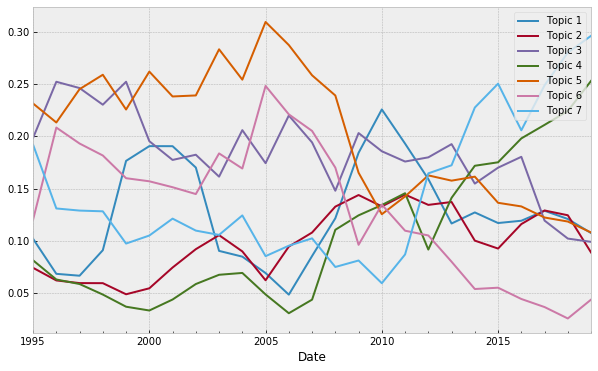

In [99]:
plt.style.use('bmh')
plt.rcParams["figure.figsize"] = (10, 6)
evolution_df.groupby('Date').mean().rolling(4,min_periods=1).mean().plot()

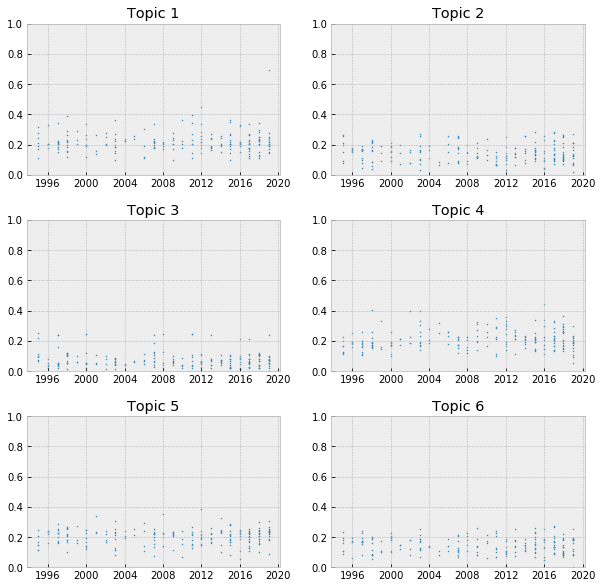

In [149]:
fig, axs = plt.subplots(3,2,figsize=(10,10),squeeze=True)
ind = 0
for ax in axs.flat:
    ax.scatter(evolution_df.index,evolution_df['Topic ' + str(ind+1)].rolling(16,min_periods = 1).mean(),s=1)
    ax.set_title('Topic '+str(ind+1))
    ax.set_ylim([0,1])
    ind+=1
plt.subplots_adjust(hspace=0.3)
plt.savefig('scatter_plots.png')

In [ ]:
top_words_df = pd.DataFrame()
for i in range(12):
    top_words_df['Topic ' + str(i+1)] = [item[0] for item in lda_model.show_topic(i,20)]

---
In the LDA modelling we only decide the number of topics present in the documents and the algorithm does the rest. However, the optimal number of topcis is difficult to find. There are many different metrics, that try to measure this "optimality". These coherence-measures, however, are far from perfect. The code below takes a lot of time to execute!

In [ ]:
# Solve the optimal number of topics
coh_list = []
perp_list = []
for i in range(20):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=id2word,num_topics=i+2,random_state=10,update_every=1,chunksize=len(corpus)/3,passes=10,alpha='auto',per_word_topics=False,eta='auto')
    coherence_model_lda = CoherenceModel(model=lda_model, texts = docs_bigrams,corpus=corpus, dictionary=id2word, coherence='u_mass')
    coh_list.append(coherence_model_lda.get_coherence())
    perp_list.append(lda_model.log_perplexity(corpus))

In [139]:
coh_list

[-1.888859285166634,
 -2.13273651575286,
 -2.254744064142424,
 -1.8751050429064129,
 -2.2347009082682026,
 -2.140283904496186,
 -2.4969653175707935,
 -3.0551487931916546,
 -2.678798483599576,
 -3.0652377660491292,
 -3.129344557561362,
 -3.1175994079110767,
 -2.7838503289083225,
 -2.7117809264194523,
 -2.5347248067915764,
 -2.476183018672886,
 -2.655225597223966,
 -2.677546910370927,
 -2.5742121767341244,
 -3.1126185074701676]

In [140]:
perp_list

[-8.081596176992743,
 -8.038457434617648,
 -8.025093633594427,
 -7.998674335325837,
 -7.994493939722446,
 -7.977502995158208,
 -7.970251381961495,
 -7.969476043413149,
 -7.981119755353663,
 -8.022565603891442,
 -8.097710921306497,
 -8.216673438851515,
 -8.330619263735134,
 -8.373028389442833,
 -8.460464878429846,
 -8.493495359737597,
 -8.531010278439073,
 -8.558490463332186,
 -8.597405473666429,
 -8.642493722529471]